# Francisco Andrés Silva Concha - Desafío - Mecanismos de Votación

**Requerimientos**

Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o impopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos registrados son de la página web.
Más información sobre los atributos se puede encontrar en el archivo <code>OnlineNewsPopularity.names</code>.

# Ejercicio 1 - Preparación del Ambiente de Trabajo

- A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función <code>grid_plot_batch</code> que se encuentra en el archivo <code>helpers.py</code>.

<code>
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
    
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']
    
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
</code>

- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función identify_high_correlations que se encuentra en el archivo <code>helpers.py<code>. Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos
con los siguientes pasos:
    - Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
    - Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#extras
import re
import helpers
import warnings
warnings.filterwarnings("ignore")

#integramos la data
df = pd.read_csv("OnlineNewsPopularity.csv")
df.head()
#Variable objetivo = "shares"

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [2]:
df.shape

(39644, 61)

In [19]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]

# codificamos la variable objetivo
df.shares = np.where(df.shares > 1400,1,0).astype('int')

# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']

In [20]:
#notamos balance de la variable objetivo
df.shares.value_counts('%')

#Es prácticamente 50% y 50%

0    0.506558
1    0.493442
Name: shares, dtype: float64

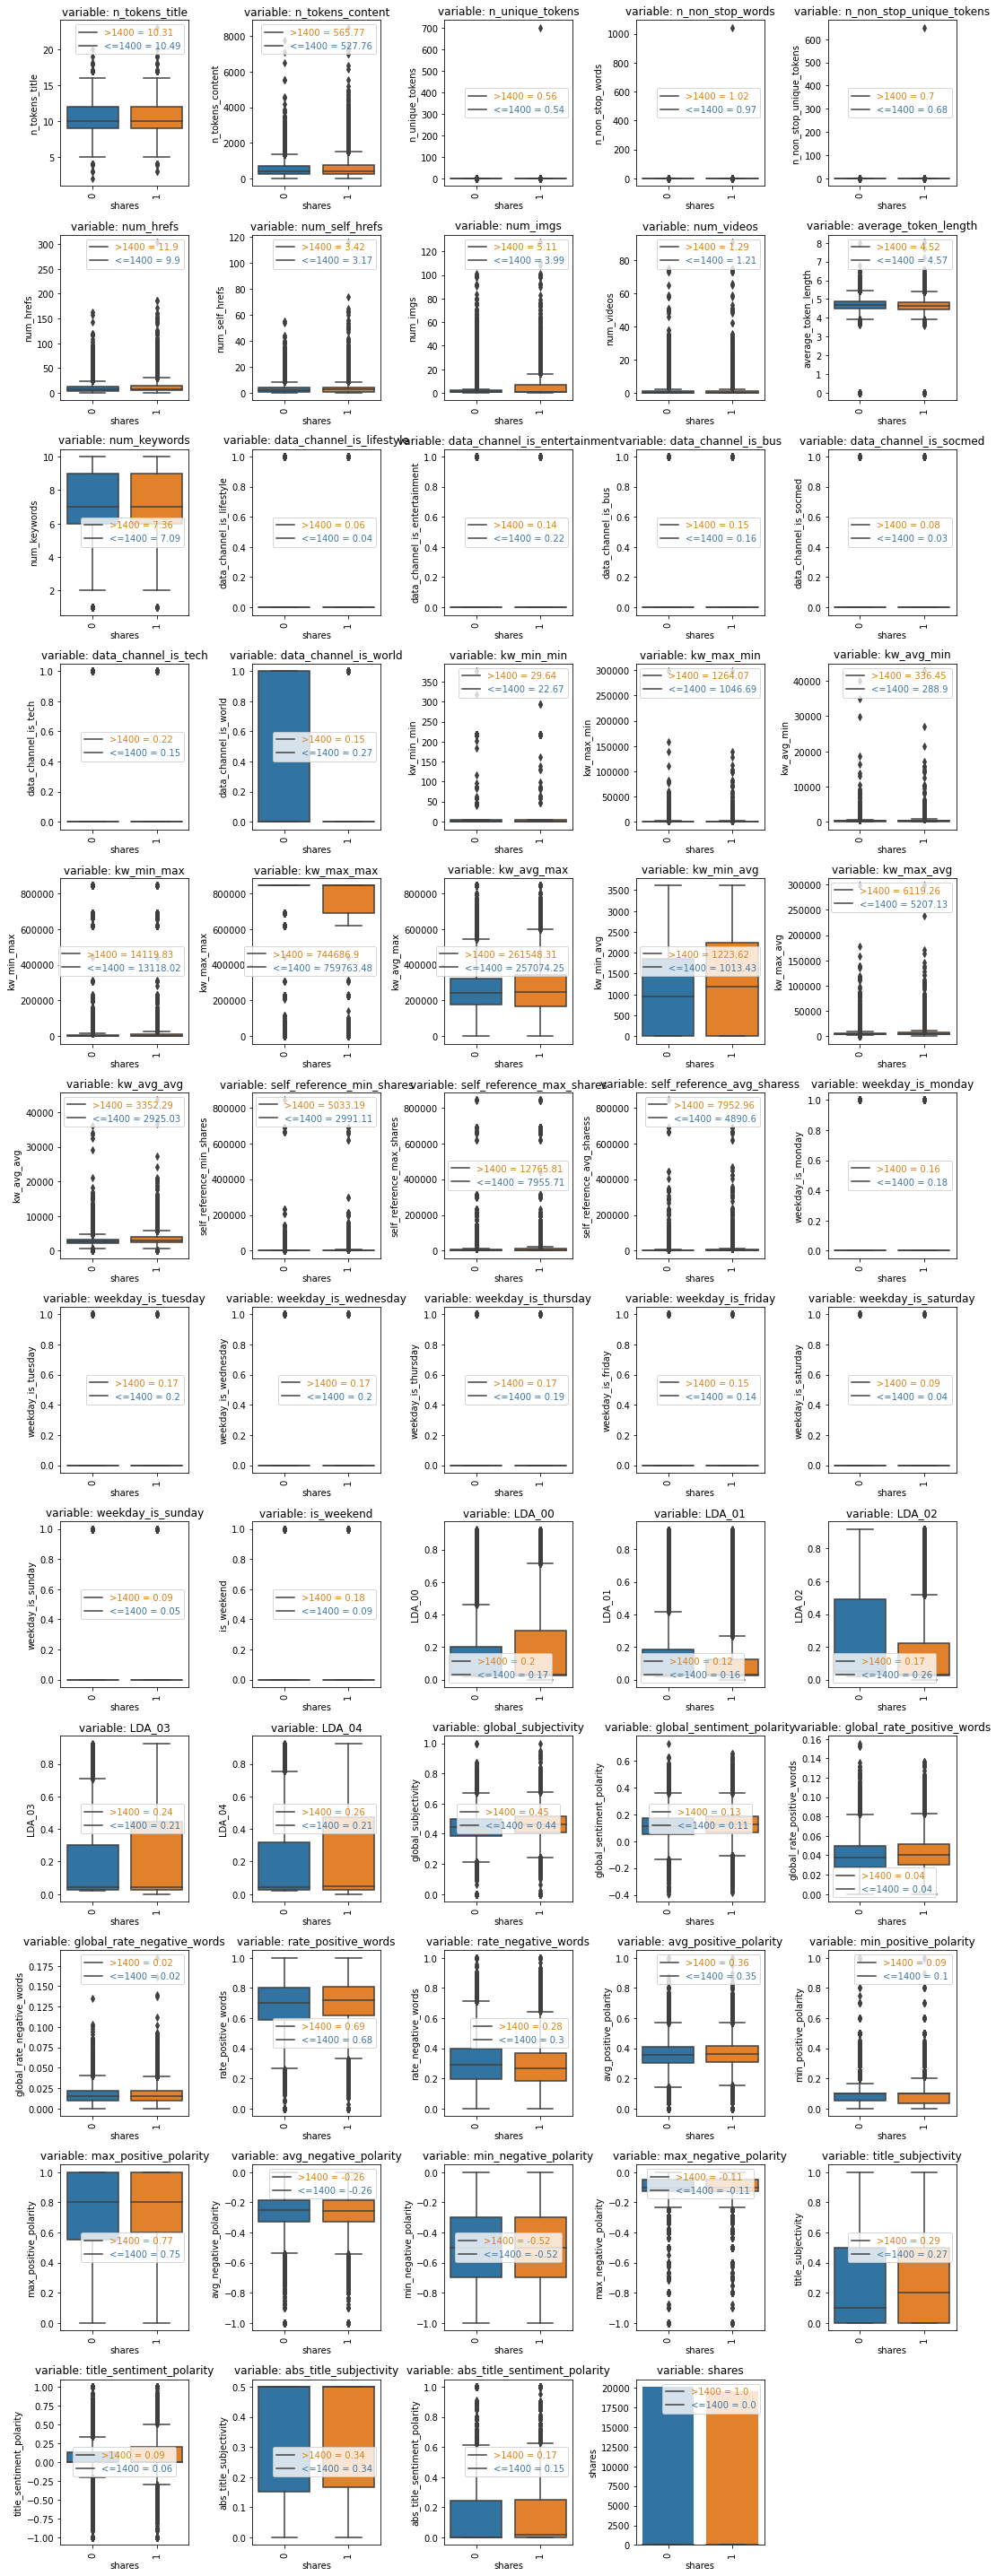

In [24]:
plt.rcParams["figure.figsize"] = (15, 40)

for n, i in enumerate(df.columns):
    plt.subplot(12, 5, n+1)
    
    if i == 'shares':
        sns.countplot(df[i])
    
    if df[i].dtype == 'object':
        ax = sns.countplot(data=df, x=i, hue='shares')
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 1, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 1, '{0:.0%}'.format(height_r/total), ha="center")
    else:
        sns.boxplot(data = df, x = 'shares', y = i)
        plt.legend(
            labels=['>1400 = '+str(round(df[df["shares"] == 1][i].mean(),2)),
                    '<=1400 = '+str(round(df[df["shares"] == 0][i].mean(),2))],
            labelcolor = [(218/255,128/255,21/255),(61/255,117/255,163/255)]
        )
    plt.xticks(rotation = 90)
    plt.title(f"variable: {i}")

plt.tight_layout()

**Comentarios**

1. n_tokens_title(Number of words in the title): No se ve información relevante comparando las 2 clases del vector objetivo.
2. n_tokens_content(Number of words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.
3. n_unique_tokens(Rate of unique words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.
4. n_non_stop_words(Rate of non-stop words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.
5. n_non_stop_unique_tokens(Rate of unique non-stop words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.

**6. num_hrefs(Number of links): En el caso de ser popular, la página popular suele tener un 20% más de links que las que no lo son.**

**7. num_self_hrefs(Number of links to other articles published by Mashable):En el caso de ser popular, las páginas tienen a tener un 10% más de links dirigiendo hacia otros artículos que las páginas que no son "populares".**

**8. num_imgs(Number of images): Interesante notar que las páginas populares tienen un 28% más de imágenes que las que no lo son.**
9. num_videos(Number of videos): No se ve información relevante comparando las 2 clases del vector objetivo.
10. average_token_length(Average length of the words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.
11. num_keywords(Number of keywords in the metadata): No se ve información relevante comparando las 2 clases del vector objetivo.

12. data_channel_is_lifestyle(Is data channel 'Lifestyle'?): No se ve información relevante comparando las 2 clases del vector objetivo.
13. data_channel_is_entertainment(Is data channel 'Entertainment'?): No se ve información relevante comparando las 2 clases del vector objetivo.
14. data_channel_is_bus(Is data channel 'Business'?): No se ve información relevante comparando las 2 clases del vector objetivo.
15. data_channel_is_socmed(Is data channel 'Social Media'?): No se ve información relevante comparando las 2 clases del vector objetivo.
16. data_channel_is_tech(Is data channel 'Tech'?): No se ve información relevante comparando las 2 clases del vector objetivo.
17. data_channel_is_world(Is data channel 'World'?): No se ve información relevante comparando las 2 clases del vector objetivo.

**18. kw_min_min(Worst keyword (min. shares)): Casi un 31% más en caso de ser una página popular que las que no.**

**19. kw_max_min(Worst keyword (max. shares)): Casi un 21% más en caso de ser una página popular que las que no.**

**20. kw_avg_min(Worst keyword (avg. shares)): Casi un 16% más en caso de ser una página popular que las que no.**

21. kw_min_max(Best keyword (min. shares)): No se ve información relevante comparando las 2 clases del vector objetivo.
22. kw_max_max(Best keyword (max. shares)): No se ve información relevante comparando las 2 clases del vector objetivo.
23. kw_avg_max(Best keyword (avg. shares)): No se ve información relevante comparando las 2 clases del vector objetivo.
**24. kw_min_avg(Avg. keyword (min. shares)): Casi un 21% más en caso de ser una página popular que las que no.**

**25. kw_max_avg(Avg. keyword (max. shares)): Casi un 18% más en caso de ser una página popular que las que no.**

**26. kw_avg_avg(Avg. keyword (avg. shares)): Casi un 15% más en caso de ser una página popular que las que no.**

**27. self_reference_min_shares(Min. shares of referenced articles in Mashable):Casi un 68% más en caso de ser una página popular que las que no.**

**28. self_reference_max_shares(Max. shares of referenced articles in Mashable):Casi un 60% más en caso de ser una página popular que las que no.**

**29. self_reference_avg_sharess(Avg. shares of referenced articles in Mashable):Casi un 64% más en caso de ser una página popular que las que no.**

30. weekday_is_monday(Was the article published on a Monday?): No se ve información relevante comparando las 2 clases del vector objetivo.
**31. weekday_is_tuesday(Was the article published on a Tuesday?):Un 15% más en caso de ser una página popular que las que no.**

**32. weekday_is_wednesday(Was the article published on a Wednesday?):Un 15% más en caso de ser una página popular que las que no.**

33. weekday_is_thursday(Was the article published on a Thursday?): No se ve información relevante comparando las 2 clases del vector objetivo.
34. weekday_is_friday(Was the article published on a Friday?): No se ve información relevante comparando las 2 clases del vector objetivo.
35. weekday_is_saturday(Was the article published on a Saturday?): No se ve información relevante comparando las 2 clases del vector objetivo.
**36. weekday_is_sunday(Was the article published on a Sunday?): Un 9% más en caso de ser una página popular que las que no.**

37. is_weekend(Was the article published on the weekend?): No se ve información relevante comparando las 2 clases del vector objetivo.

**38. LDA_00(Closeness to LDA topic 0): Un 15% MENOS en caso de ser una página popular que las que no.**

39. LDA_01(Closeness to LDA topic 1): No se ve información relevante comparando las 2 clases del vector objetivo.
**40. LDA_02( Closeness to LDA topic 2): Un 9% MEN OS en caso de ser una página popular que las que no.**

41. LDA_03(Closeness to LDA topic 3): No se ve información relevante comparando las 2 clases del vector objetivo.
42. LDA_04(Closeness to LDA topic 4): No se ve información relevante comparando las 2 clases del vector objetivo.

43. global_subjectivity(Text subjectivity): No se ve información relevante comparando las 2 clases del vector objetivo.
44. global_sentiment_polarity(Text sentiment polarity): No se ve información relevante comparando las 2 clases del vector objetivo.
45. global_rate_positive_words(Rate of positive words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.
46. global_rate_negative_words(Rate of negative words in the content): No se ve información relevante comparando las 2 clases del vector objetivo.

47. rate_positive_words(Rate of positive words among non-neutral tokens): No se ve información relevante comparando las 2 clases del vector objetivo.
**48. rate_negative_words(Rate of negative words among non-neutral tokens): Un 26% más en caso de ser una página popular que las que no.**

49. avg_positive_polarity(Avg. polarity of positive words): No se ve información relevante comparando las 2 clases del vector objetivo.
50. min_positive_polarity(Min. polarity of positive words): No se ve información relevante comparando las 2 clases del vector objetivo.
51. max_positive_polarity(Max. polarity of positive words): No se ve información relevante comparando las 2 clases del vector objetivo.
52. avg_negative_polarity(Avg. polarity of negative  words): No se ve información relevante comparando las 2 clases del vector objetivo.
53. min_negative_polarity(Min. polarity of negative  words): No se ve información relevante comparando las 2 clases del vector objetivo.
54. max_negative_polarity(Max. polarity of negative  words): No se ve información relevante comparando las 2 clases del vector objetivo.

55. title_subjectivity(Title subjectivity): No se ve información relevante comparando las 2 clases del vector objetivo.
56. title_sentiment_polarity(Title polarity): No se ve información relevante comparando las 2 clases del vector objetivo.
57. abs_title_subjectivity(Absolute subjectivity level): No se ve información relevante comparando las 2 clases del vector objetivo.
58. abs_title_sentiment_polarity(Absolute polarity level): No se ve información relevante comparando las 2 clases del vector objetivo.

# Ejercicio 2 - Evaluación de modelos individuales

- A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
     - Importe los módulos correctamente.
     - Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision, Recall, F1. Puede hacer uso de la función plot_classification_report disponible en el archivo <code>helpers.py<code>.
- Comente el desempeño general de cada uno.
    
- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    - Regresión Logística.
    - Algoritmo de KMedias.
    - Árbol de Clasificación con un max_depth=1.
    - Árbol de Clasificación con un max_depth=4.

In [113]:
#importamos los algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

#metrics (se agregaron en total 4 para un mejor ejercicio >:})
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#model_selection
from sklearn.model_selection import train_test_split

In [114]:
#Separamos las muestras en X e y
X = df.drop(columns='shares')
y = df.shares

#Separamos X e Y en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

#Regresión Logística
lr = LogisticRegression(random_state=123).fit(X_train, y_train)

#Kmeans
km = KMeans(n_clusters=2, random_state=123).fit(X_train)

#Decision Trees
dt1 = DecisionTreeClassifier(max_depth=1, random_state=123).fit(X_train, y_train)
dt4 = DecisionTreeClassifier(max_depth=4, random_state=123).fit(X_train, y_train)

In [115]:
#Creamos DataFrame para los resultados
results = pd.DataFrame()

for i in [lr, km, dt1, dt4]:
    y_pred = i.predict(X_test)
    results = results.append({"model":str(i),
                    "accuracy":accuracy_score(y_test, y_pred),
                    "recall":recall_score(y_test, y_pred),
                    "precision":precision_score(y_test, y_pred),
                    "f1-score":f1_score(y_test, y_pred)
                   }, ignore_index=True
                  )
results = pd.melt(frame=results, id_vars=['model'], value_vars =['accuracy', 'f1-score','precision', 'recall'])
results

,model,variable,value
0,LogisticRegression(random_state=123),accuracy,0.590996
1,"KMeans(n_clusters=2, random_state=123)",accuracy,0.509898
2,"DecisionTreeClassifier(max_depth=1, random_sta...",accuracy,0.594283
3,"DecisionTreeClassifier(max_depth=4, random_sta...",accuracy,0.632424
4,LogisticRegression(random_state=123),f1-score,0.557146
5,"KMeans(n_clusters=2, random_state=123)",f1-score,0.142551
6,"DecisionTreeClassifier(max_depth=1, random_sta...",f1-score,0.604353
7,"DecisionTreeClassifier(max_depth=4, random_sta...",f1-score,0.614138
8,LogisticRegression(random_state=123),precision,0.601824
9,"KMeans(n_clusters=2, random_state=123)",precision,0.539474


<AxesSubplot:xlabel='variable', ylabel='value'>

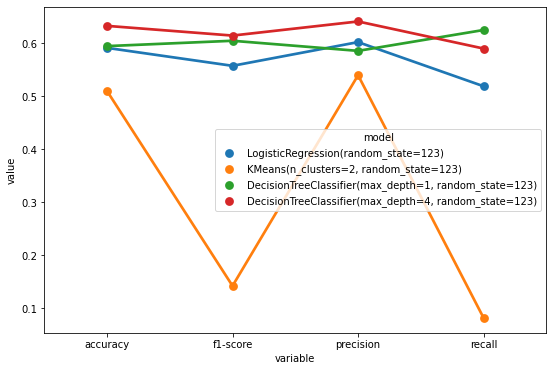

In [116]:
plt.rcParams["figure.figsize"] = (9, 6)
sns.pointplot(data=results, x= 'variable', y='value', hue='model')

**Comentarios**

En términos generales, dt4 es el que tiene mejores métricas, a excepción del recall, donde fue el stump (dt1) que logró mejor puntaje que dt4

# Ejercicio 3 - Entrenamiento de Comité

- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.

In [117]:
#Tenemos que recrear los algoritmos sin hacer fit en ellos
#Regresión Logística
lr = LogisticRegression(random_state=123)

#Kmeans
km = KMeans(n_clusters=2, random_state=123)

#Decision Trees
dt1 = DecisionTreeClassifier(max_depth=1, random_state=123)
dt4 = DecisionTreeClassifier(max_depth=4, random_state=123)

estimators=[('lr', LogisticRegression(random_state=123)),
            ('km', KMeans(n_clusters=2, random_state=123)),
            ('dt1', DecisionTreeClassifier(max_depth=1, random_state=123)),
            ('dt4', DecisionTreeClassifier(max_depth=4, random_state=123))
            ]
estimators[1][1]._estimator_type = 'classifier'

vc =VotingClassifier(estimators=estimators).fit(X_train, y_train)

y_pred = vc.predict(X_test)

results = results.append({'model':'vc','variable':'accuracy','value':accuracy_score(y_test, y_pred)}, ignore_index=True)
results = results.append({'model':'vc','variable':'recall','value':recall_score(y_test, y_pred)}, ignore_index=True)
results = results.append({'model':'vc','variable':'precision','value':precision_score(y_test, y_pred)}, ignore_index=True)
results = results.append({'model':'vc','variable':'f1-score','value':f1_score(y_test, y_pred)}, ignore_index=True)

<AxesSubplot:xlabel='variable', ylabel='value'>

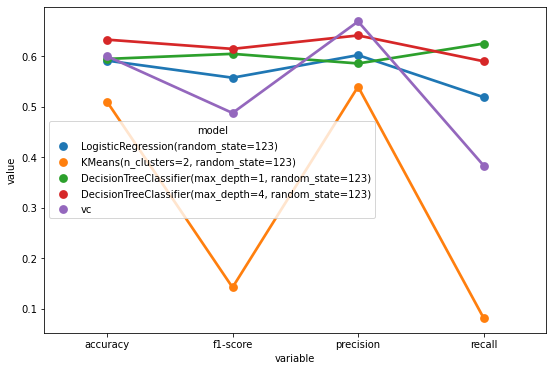

In [118]:
sns.pointplot(data=results, x= 'variable', y='value', hue='model')

**Comentario**

Curiosamente el modelo VotingClassifier sólo logró mejores métricas en "precision", en el resto mostró un pero desempeño, esto es debido quizás a que los pesos de cada modelo no son los más adecuados, o que el modelo lo está asignando por igual, una forma de mejorarlo es quizás sacando KMeans del listado de estimadores.

# Ejercicio 4 - Calibración de Comité con Ponderadores

- En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo.

**Propuestas**

Si el vector estimators se compone de :

    a) ('lr', LogisticRegression(random_state=123))
    b) ('km', KMeans(n_clusters=2, random_state=123))
    c) ('dt1', DecisionTreeClassifier(max_depth=1, random_state=123))
    d) ('dt4', DecisionTreeClassifier(max_depth=4, random_state=123))

Entonces los pesos propuestos son los siguientes:

1) [0.25, 0.00, 0.25, 0.50]
2) [0.40, 0.00, 0.20, 0.40]
3) [0.20, 0.00, 0.40, 0.40]

In [119]:
pesos =  [[0.33, 0.00, 0.33, 0.34],
          [0.20, 0.00, 0.40, 0.40],
          [0.10, 0.00, 0.45, 0.45],
          [0.15, 0.15, 0.35, 0.35],
         ]

for i in range(2,5):
    tpm_model = VotingClassifier(estimators=estimators, weights=pesos[i-2]).fit(X_train, y_train)

    y_pred = tpm_model.predict(X_test)

    results = results.append({'model':'vc'+str(i),'variable':'accuracy','value':accuracy_score(y_test, y_pred)}, ignore_index=True)
    results = results.append({'model':'vc'+str(i),'variable':'recall','value':recall_score(y_test, y_pred)}, ignore_index=True)
    results = results.append({'model':'vc'+str(i),'variable':'precision','value':precision_score(y_test, y_pred)}, ignore_index=True)
    results = results.append({'model':'vc'+str(i),'variable':'f1-score','value':f1_score(y_test, y_pred)}, ignore_index=True)


<AxesSubplot:xlabel='variable', ylabel='value'>

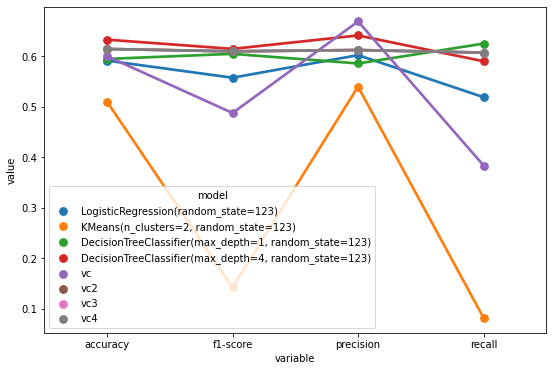

In [120]:
sns.pointplot(data=results, x= 'variable', y='value', hue='model')


In [122]:
results[results['model'] == 'vc4']

,model,variable,value
28,vc4,accuracy,0.614003
29,vc4,recall,0.606780
30,vc4,precision,0.611871
31,vc4,f1-score,0.609315


**Comentario**

Al ver el gráfico, el mejor desempeño de los modelos de ensable heterogéneo es modelo vc4, el cual tiene pesos [0.15, 0.15, 0.35, 0.35], que de alguna forma logra estar entre los dos árboles de decisión, las métrica de este están en el  output anterior